In [1]:
%matplotlib inline
from IPython.display import Image

In [2]:
import os
def create_folder(path):
    if not os.path.isdir(path):
        os.mkdir(path)

In [3]:
if 'google.colab' in str(get_ipython()):
    print('Cloning code base to colab....')
    !git clone https://github.com/ZefangWang/generalization_to_OOD_category_viewpoint_combinations.git
    !cd generalization_to_OOD_category_viewpoint_combinations/utils && bash download_mnist_rotation.sh
    CODE_ROOT = "generalization_to_OOD_category_viewpoint_combinations/"
else:
    CODE_ROOT = '..'

Cloning code base to colab....
fatal: destination path 'generalization_to_OOD_category_viewpoint_combinations' already exists and is not an empty directory.
--2022-04-19 05:57:30--  https://www.dropbox.com/s/wdws3b3fjo190sk/self_generated.tar.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.70.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.70.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/wdws3b3fjo190sk/self_generated.tar.gz [following]
--2022-04-19 05:57:31--  https://www.dropbox.com/s/raw/wdws3b3fjo190sk/self_generated.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1e74ac88ce51a0ea80e607b4d6.dl.dropboxusercontent.com/cd/0/inline/Bjr63AxgHTmTdR25t6H_ngJlEkAXPV_LkLw6hGKpQj3yTfCTO7d5cceSqhJt7YMLwdNgIkbCMw87_hmg2TRLAAIoFDX-LsCHo9IbwwPGwbRdVPUpKZ2CEzb7w-AdVb1SBQQfYIdafZdLS4f_yUFncnQoKI8czhTElLuId-4Qd

In [4]:
# CODE_ROOT = '..'

In [5]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os
from PIL import ImageFile
import random
ImageFile.LOAD_TRUNCATED_IMAGES = True
import argparse
import pickle
import sys
sys.path.append('%s/res/'%CODE_ROOT)
from models.models import get_model
from loader.loader import get_loader
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
sns.set_palette("Set1", 8, .75)
sns.despine()

/content
generalization_to_OOD_category_viewpoint_combinations//res/loader/loader.py
generalization_to_OOD_category_viewpoint_combinations//res/loader


<Figure size 432x288 with 0 Axes>

In [6]:
DATASET_NAMES = ['mnist_rotation_one_by_nine', 'mnist_rotation_three_by_nine',
                 'mnist_rotation_six_by_nine', 'mnist_rotation_nine_by_nine']
NUM_EPOCHS = 5
BATCH_SIZE = 100
ARCHS =['EARLY_BRANCHING_COMBINED','SPLIT_AFTER_ONE_BLOCK', 'LATE_BRANCHING_COMBINED', 'LATE_BRANCHING_COMBINED_WIDER',  'LATE_BRANCHING_COMBINED_ONE_FOURTH', 'MULTITASK_INCEPTION_WIDE', 'MULTITASK_RESNEXT_WIDE',  'MULTITASK_RESNEXT', 'LATE_BRANCHING_COMBINED_HALF','Multitask_Resnet_Early_New',  'SPLIT_AFTER_THREE_BLOCKS', 'Two_Block_Encoder_Long_Decoder']

image_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])


GPU = 1

In [7]:
NUM_CLASSES = (10,10,10,10)
loader_new = get_loader('multi_attribute_loader_file_list_mnist_rotation')

file_list_root = '%s/dataset_lists/mnist_rotation_lists/'%CODE_ROOT
att_path = '%s/dataset_lists/combined_attributes.p'%CODE_ROOT

In [8]:
shuffles = {'train':True,'val':True,'test':False}

In [9]:
data_dir = '%s/data/'%CODE_ROOT

In [10]:
all_dsets = {}
all_dset_loaders = {}
all_dset_sizes = {}

for DATASET_NAME in DATASET_NAMES:
    file_lists = {}
    dsets = {}
    dset_loaders = {}
    dset_sizes = {}
    for phase in ['train','val','test']:
        file_lists[phase] = "%s/%s_list_%s.txt"%(file_list_root,phase,DATASET_NAME)
        dsets[phase] = loader_new(file_lists[phase],att_path, image_transform, data_dir)
        dset_loaders[phase] = torch.utils.data.DataLoader(dsets[phase], batch_size=BATCH_SIZE, shuffle = shuffles[phase], num_workers=2,drop_last=True)
        dset_sizes[phase] = len(dsets[phase])
    all_dsets[DATASET_NAME] = dsets
    all_dset_loaders[DATASET_NAME] = dset_loaders
    all_dset_sizes[DATASET_NAME] = dset_sizes

In [11]:
all_dsets

{'mnist_rotation_nine_by_nine': {'test': Dataset FileListFolder
      Number of datapoints: 10000
      Root Location: generalization_to_OOD_category_viewpoint_combinations//dataset_lists/mnist_rotation_lists//test_list_mnist_rotation_nine_by_nine.txt
      Transforms (if any): Compose(
                               ToTensor()
                               Normalize(mean=(0.1307,), std=(0.3081,))
                           ), 'train': Dataset FileListFolder
      Number of datapoints: 50000
      Root Location: generalization_to_OOD_category_viewpoint_combinations//dataset_lists/mnist_rotation_lists//train_list_mnist_rotation_nine_by_nine.txt
      Transforms (if any): Compose(
                               ToTensor()
                               Normalize(mean=(0.1307,), std=(0.3081,))
                           ), 'val': Dataset FileListFolder
      Number of datapoints: 10000
      Root Location: generalization_to_OOD_category_viewpoint_combinations//dataset_lists/mnist_rotatio

In [12]:
class sgan_Generator(nn.Module):
    def __init__(self, n_classes, latent_dim, image_size):
        super(Generator, self).__init__()
        self.n_classes = n_classes
        self.latent_dim = latent_dim
        self.image_size = image_size

        self.label_emb = nn.Embedding(self.n_classes, self.latent_dim)

        self.init_size = self.image_size // 4 
        self.l1 = nn.Sequential(nn.Linear(self.latent_dim, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, noise, labels):
        gen_input = torch.mul(self.label_emb(labels), noise)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

In [13]:
class sgan_Discriminator(nn.Module):
    def __init__(self, n_classes, latent_dim, image_size):
        super(Discriminator, self).__init__()
        self.n_classes = n_classes
        self.latent_dim = latent_dim
        self.image_size = image_size


        def discriminator_block(in_filters, out_filters, bn=True):
            """Returns layers of each discriminator block"""
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.conv_blocks = nn.Sequential(
            *discriminator_block(opt.channels, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = opt.img_size // 2 ** 4

        # Output layers
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())
        self.aux_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2,  self.n_classes), nn.Softmax())

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.view(out.shape[0], -1)
        validity = self.adv_layer(out)
        label = self.aux_layer(out)

        return validity, label

In [14]:
adversarial_loss = torch.nn.BCELoss()
auxiliary_loss = torch.nn.CrossEntropyLoss()

In [15]:
class DCGAN_Generator(nn.Module):
    def __init__(self):
        super(DCGAN_Generator,self).__init__()
        self.gnet = nn.Sequential(
            nn.ConvTranspose2d(128, 512, 3, 1, 0),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(512, 256, 5, 2, 1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(256, 128, 5, 2, 2, 1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 1, 5, 2, 2, 1),
            nn.Tanh()
        )


    def forward(self, input):     
        out = self.gnet(input)
        return out


class DCGAN_Discriminator(nn.Module):
    def __init__(self):
        super(DCGAN_Discriminator, self).__init__()
        self.dnet = nn.Sequential(
            nn.Conv2d(1, 128, 5, 2, 2),
            nn.LeakyReLU(0.2), 
            nn.Conv2d(128, 256, 5, 2, 2),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, 5, 2, 1), 
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, 3, 1, 0),
            nn.Sigmoid()
        )
        
        
    
    def forward(self, input):

        bs, _, _, _ = input.shape
        out = self.dnet(input)
        out = out.reshape(bs, -1)
        return out

In [16]:
def loss_discriminator(D, real, G, noise, Valid_label, Fake_label, criterion, optimizerD):

    D.zero_grad()
    real_out = D(real).view(-1)
    d_real_loss = criterion(real_out,Valid_label)
    d_real_loss.backward()
    fake_imgs = G(noise)
    fake_out = D(fake_imgs.detach()).view(-1)
    d_fake_loss = criterion(fake_out, Fake_label)
    d_fake_loss.backward()
    loss_D = d_fake_loss+d_real_loss
    optimizerD.step()

    return loss_D, fake_imgs

def loss_generator(netD, netG, fake, Valid_label, criterion, optimizerG):
    
    netG.zero_grad()
    fake_out = netD(fake).view(-1)
    loss_G = criterion(fake_out, Valid_label)
    loss_G.backward()
    optimizerG.step()
   
    return loss_G

In [17]:
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nc = 3
nz = 128

# netG = DCGAN_Generator().to(device)
# netD = DCGAN_Discriminator().to(device)


In [18]:
multi_losses = [nn.CrossEntropyLoss(),nn.CrossEntropyLoss(),nn.CrossEntropyLoss(),nn.CrossEntropyLoss()]

In [19]:
ARCHS = ['acgan','wgan','sgan']

In [20]:
import torchvision.utils as vutils
from torch.optim.lr_scheduler import StepLR
import pdb
def train_gan(gan_train_loader, DCGAN_Generator, DCGAN_Discriminator):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    nc = 3
    nz = 128

    # Create the generator and discriminator
    netG = DCGAN_Generator().to(device)
    netD = DCGAN_Discriminator().to(device)

    # Initialize BCELoss function
    criterion = nn.BCELoss()
    # criterion = nn.BCEWithLogitsLoss()

    # Create latent vector to test the generator performance
    fixed_noise = torch.randn(36, nz, 1, 1, device=device)

    # Establish convention for real and fake labels during training
    real_label = 1
    fake_label = 0

    learning_rate = 0.0001
    beta1 = 0.5



    optimizerD = optim.Adam(netD.parameters(), lr=learning_rate, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=learning_rate, betas=(beta1, 0.999))




    img_list = []
    real_img_list = []
    G_losses = []
    D_losses = []
    iters = 0
    num_epochs = 15


    def load_param(num_eps):
      model_saved = torch.load('/content/gan_{}.pt'.format(num_eps))
      netG.load_state_dict(model_saved['netG'])
      netD.load_state_dict(model_saved['netD'])

    # GAN Training Loop
    for epoch in range(num_epochs):
        for i, data in enumerate(gan_train_loader, 0):
            real = data[0].to(device)
            b_size = real.size(0)
            noise = torch.randn(b_size, nz, 1, 1, device=device)

            Valid_label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
            Fake_label = torch.full((b_size,), fake_label, dtype=torch.float, device=device)

            loss_D, fake_imgs = loss_discriminator(netD, real, netG, noise, Valid_label, Fake_label, criterion, optimizerD)
           
            loss_G = loss_generator(netD, netG, fake_imgs, Valid_label, criterion, optimizerG)

            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\t'
                      % (epoch, num_epochs, i, len(gan_train_loader),
                         loss_D.item(), loss_G.item()))

            G_losses.append(loss_G.item())
            D_losses.append(loss_D.item())

            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(gan_train_loader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1



    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


    checkpoint = {'netG': netG.state_dict(),
                  'netD': netD.state_dict()}
    torch.save(checkpoint, 'gan_{}.pt'.format(num_epochs))


In [21]:
def weight_scheduler(epoch_num, task):
    if task == 'shared':
        return [0.0,1.0,0.0,1.0]
    elif task == 'viewpoint':
        return [0.0,1.0,0.0,0.0]
    elif task == 'category':
        return [0.0,0.0,0.0,1.0]

In [22]:
def train_epoch(dset_loaders, dset_sizes, model, task, optimizer):
    model.train()
    torch.set_grad_enabled(True)
    phase = 'train'
    
    weights = weight_scheduler(epoch, task)
    iters = 0
    phase_epoch_corrects = [0,0,0,0]
    phase_epoch_loss = 0
    
    for data in dset_loaders[phase]:
        inputs, labels_all, paths = data
        inputs = Variable(inputs.float().cuda())

        optimizer.zero_grad()
        model_outs = model(inputs)
        calculated_loss = 0
        batch_corrects = [0,0,0,0]
        
        for i in range(4):
            labels = labels_all[:,i]
            if GPU:
                labels = Variable(labels.long().cuda())
            loss = multi_losses[i]
            outputs = model_outs[i]
            calculated_loss += weights[i] * loss(outputs,labels)
            _, preds = torch.max(outputs.data, 1)
            batch_corrects[i] = torch.sum(preds == labels.data)
            phase_epoch_corrects[i] += batch_corrects[i]

        
        phase_epoch_loss += calculated_loss
        calculated_loss.backward()
        optimizer.step()
        iters += 1
    epoch_loss = phase_epoch_loss/dset_sizes[phase]
    # print('Train loss:%s'%epoch_loss)
    epoch_accs = [float(i)/dset_sizes[phase] for i in phase_epoch_corrects]

    if task == 'shared':
        epoch_gm = np.sqrt(epoch_accs[1] * epoch_accs[3])
    elif task == 'viewpoint':
        epoch_gm = epoch_accs[1]
    elif task == 'category':
        epoch_gm = epoch_accs[3]
    
    return model, epoch_loss, epoch_gm

In [23]:
def test_epoch(dset_loaders, dset_sizes, model, best_model, best_test_loss, best_test_gm, task):
    model.eval()
    torch.set_grad_enabled(False)
    phase = 'val'
    weights = weight_scheduler(epoch, task)
    iters = 0
    phase_epoch_corrects = [0,0,0,0]
    phase_epoch_loss = 0
    
    for data in dset_loaders[phase]:
        inputs, labels_all, paths = data
        inputs = Variable(inputs.float().cuda())
        model_outs = model(inputs)
        calculated_loss = 0
        batch_corrects = [0,0,0,0]
        
        for i in range(4):
            labels = labels_all[:,i]
            if GPU:
                labels = Variable(labels.long().cuda())
            loss = multi_losses[i]
            outputs = model_outs[i]
            calculated_loss += weights[i] * loss(outputs,labels)
            _, preds = torch.max(outputs.data, 1)
            batch_corrects[i] = torch.sum(preds == labels.data)
            phase_epoch_corrects[i] += batch_corrects[i]


        phase_epoch_loss += calculated_loss
        iters += 1
    epoch_loss = phase_epoch_loss/dset_sizes[phase]
    # print('Test loss:%s'%epoch_loss)
    epoch_accs = [float(i)/dset_sizes[phase] for i in phase_epoch_corrects]
    
    if task == 'shared':
        epoch_gm = np.sqrt(epoch_accs[1] * epoch_accs[3])
    elif task == 'viewpoint':
        epoch_gm = epoch_accs[1]
    elif task == 'category':
        epoch_gm = epoch_accs[3]
    
    if epoch_loss < best_test_loss:
        best_model = model
        best_test_loss = epoch_loss
        best_test_gm = epoch_gm
    
    return best_model, epoch_loss, epoch_gm, best_test_loss, best_test_gm

In [24]:
def unseen_test_epoch(dset_loaders, dset_sizes, model, task):
    model.eval()
    torch.set_grad_enabled(False)
    phase = 'test'

    weights = weight_scheduler(epoch, task)
    iters = 0
    phase_epoch_corrects = [0,0,0,0]
    phase_epoch_loss = 0
    
    for data in dset_loaders[phase]:
        inputs, labels_all, paths = data
        inputs = Variable(inputs.float().cuda())
        model_outs = model(inputs)
        calculated_loss = 0
        batch_corrects = [0,0,0,0]
        
        for i in range(4):
            labels = labels_all[:,i]
            if GPU:
                labels = Variable(labels.long().cuda())
            loss = multi_losses[i]
            outputs = model_outs[i]
            calculated_loss += weights[i] * loss(outputs,labels)
            _, preds = torch.max(outputs.data, 1)
            batch_corrects[i] = torch.sum(preds == labels.data)
            phase_epoch_corrects[i] += batch_corrects[i]


        phase_epoch_loss += calculated_loss
        iters += 1
    epoch_loss = phase_epoch_loss/dset_sizes[phase]
    epoch_accs = [float(i)/dset_sizes[phase] for i in phase_epoch_corrects]
    
    if task == 'shared':
        epoch_gm = np.sqrt(epoch_accs[1] * epoch_accs[3])
    elif task == 'viewpoint':
        epoch_gm = epoch_accs[1]
    elif task == 'category':
        epoch_gm = epoch_accs[3]
    
    return epoch_loss, epoch_gm

In [25]:
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

In [26]:
DATASET_NAMES

['mnist_rotation_one_by_nine',
 'mnist_rotation_three_by_nine',
 'mnist_rotation_six_by_nine',
 'mnist_rotation_nine_by_nine']

In [27]:
dataset_titles = {}
dataset_titles['mnist_rotation_one_by_nine'] = "10% combinations seen"
dataset_titles['mnist_rotation_three_by_nine'] = "30% combinations seen"
dataset_titles['mnist_rotation_six_by_nine'] = "60% combinations seen"
dataset_titles['mnist_rotation_nine_by_nine'] = "90% combinations seen"

In [28]:
all_train_all = {}
all_test_all = {}
all_unseen_test_all = {}


In [29]:
for ARCH in ARCHS:
  all_train_all[ARCH + ' ' + 'shared'] = []
  all_train_all[ARCH + ' ' +'separate'] = []

  all_test_all[ARCH + ' ' +'shared'] = []
  all_test_all[ARCH + ' ' +'separate'] = []

  all_unseen_test_all[ARCH + ' ' +'shared'] = []
  all_unseen_test_all[ARCH + ' ' + 'separate'] = []

  for DATASET_NAME in DATASET_NAMES:
      print('______________________________________________________')
      print('model_name:',ARCH,'  comb_name', dataset_titles[DATASET_NAME])
      dsets = all_dsets[DATASET_NAME]
      dset_loaders = all_dset_loaders[DATASET_NAME]
      dset_sizes = all_dset_sizes[DATASET_NAME]
      
      models = {}

      models['shared']= get_model(ARCH,NUM_CLASSES)
      models['viewpoint']= get_model(ARCH,NUM_CLASSES)
      models['category']= get_model(ARCH,NUM_CLASSES)

      models['shared'].cuda();
      models['viewpoint'].cuda();
      models['category'].cuda();

      best_models = {}
      best_models['shared'] = models['shared']
      best_models['viewpoint'] = models['viewpoint']
      best_models['category'] = models['category']

      best_test_loss = 100
      best_test_gm = 0

      all_train_gms = {}
      all_train_gms['shared'] = [0]
      all_train_gms['separate'] = [0]

      all_test_gms = {}
      all_test_gms['shared'] = [0]
      all_test_gms['separate'] = [0]

      all_unseen_test_gms = {}
      all_unseen_test_gms['shared'] = [0]
      all_unseen_test_gms['separate'] = [0]

      optimizers = {}
      optimizers['shared'] = optim.Adam(models['shared'].parameters(), lr=0.001)
      optimizers['viewpoint'] = optim.Adam(models['viewpoint'].parameters(), lr=0.001)
      optimizers['category'] = optim.Adam(models['category'].parameters(), lr=0.001)
      for epoch in range(NUM_EPOCHS):
          train_gm_separate = 1
          test_gm_separate = 1
          unseen_test_gm_separate = 1

          for TASK in ['viewpoint','category','shared']:
              print('Epoch: %s, Task: %s'%(epoch,TASK))
              print('---------')
              models[TASK], train_loss, train_gm = train_epoch(dset_loaders, dset_sizes, models[TASK], TASK, optimizers[TASK])
              best_models[TASK], test_loss, test_gm, best_test_loss, best_test_gm = test_epoch(dset_loaders, dset_sizes, models[TASK], best_models[TASK], best_test_loss, best_test_gm, TASK)
              unseen_test_loss, unseen_test_gm = unseen_test_epoch(dset_loaders, dset_sizes, models[TASK], TASK)

              if TASK != 'shared':
                  train_gm_separate = train_gm_separate * train_gm
                  test_gm_separate = test_gm_separate * test_gm
                  unseen_test_gm_separate = unseen_test_gm_separate * test_gm

          all_train_gms['separate'].append(np.sqrt(train_gm_separate))
          all_test_gms['separate'].append(np.sqrt(test_gm_separate))
          all_unseen_test_gms['separate'].append(np.sqrt(unseen_test_gm_separate))
          all_train_gms['shared'].append(train_gm)
          all_test_gms['shared'].append(test_gm)
          all_unseen_test_gms['shared'].append(np.sqrt(unseen_test_gm))



      all_train_all[ARCH + ' ' +'separate'].append(np.sqrt(train_gm_separate))
      all_test_all[ARCH + ' ' +'separate'].append(np.sqrt(test_gm_separate))
      all_unseen_test_all[ARCH + ' ' +'separate'].append(np.sqrt(unseen_test_gm_separate))
      all_train_all[ARCH + ' ' +'shared'].append(train_gm)
      all_test_all[ARCH + ' ' +'shared'].append(test_gm)
      all_unseen_test_all[ARCH + ' ' +'shared'].append(np.sqrt(unseen_test_gm))
      print(all_train_all)
      

      



      # fig,ax = plt.subplots(1, 3, figsize=(18,6))
      # fig.suptitle(dataset_titles[DATASET_NAME], fontsize = 30)
      # l1 = ax[0].plot(all_train_gms['separate'], color = 'blue', marker = 'o', markersize=5)[0]
      # l2 = ax[0].plot(all_train_gms['shared'], color = 'red', marker = 'o', markersize=5)[0]
      # ax[0].set_title('Train Accuracy', fontsize=12)
      # line_labels = ["Separate", "Shared"]

      # ax[1].plot(all_test_gms['separate'], color = 'blue', marker = 'o', markersize=5)
      # ax[1].plot(all_test_gms['shared'], color = 'red', marker = 'o', markersize=5)
      # ax[1].set_title('Test Accuracy on Seen \n Category-Viewpoint Combinations', fontsize=12)

      # ax[2].plot(all_unseen_test_gms['separate'], color = 'blue', marker = 'o', markersize=5)
      # ax[2].plot(all_unseen_test_gms['shared'], color = 'red', marker = 'o', markersize=5)
      # ax[2].set_title('Test Accuracy on Unseen \n Category-Viewpoint Combinations', fontsize=12)
      # fig.legend([l1, l2],     # The line objects
      #         labels=line_labels,   # The labels for each line
      #         loc="center right",   # Position of legend
      #         borderaxespad=0.2,    # Small spacing around legend box
      #         prop={"size":20})
      # plt.subplots_adjust(right=0.85, top =0.80)
      # plt.show()

______________________________________________________
model_name: acgan   comb_name 10% combinations seen
Epoch: 0, Task: viewpoint
---------
Epoch: 0, Task: category
---------
Epoch: 0, Task: shared
---------
Epoch: 1, Task: viewpoint
---------
Epoch: 1, Task: category
---------
Epoch: 1, Task: shared
---------
Epoch: 2, Task: viewpoint
---------
Epoch: 2, Task: category
---------
Epoch: 2, Task: shared
---------
Epoch: 3, Task: viewpoint
---------
Epoch: 3, Task: category
---------
Epoch: 3, Task: shared
---------
Epoch: 4, Task: viewpoint
---------
Epoch: 4, Task: category
---------
Epoch: 4, Task: shared
---------
{'acgan shared': [0.49765572035293637], 'acgan separate': [0.990608080726177]}
______________________________________________________
model_name: acgan   comb_name 30% combinations seen
Epoch: 0, Task: viewpoint
---------
Epoch: 0, Task: category
---------
Epoch: 0, Task: shared
---------
Epoch: 1, Task: viewpoint
---------
Epoch: 1, Task: category
---------
Epoch: 1, Ta

In [30]:
percentage = [0.1, 0.3, 0.6, 0.9]

In [31]:
all_train_all

{'acgan separate': [0.990608080726177,
  0.9820075580157211,
  0.9565131781632702,
  0.9682545665267993],
 'acgan shared': [0.49765572035293637,
  0.49628954774405637,
  0.4921200280419402,
  0.49190365235480815],
 'sgan separate': [0.9940199981891712,
  0.9854597653887245,
  0.9655746353337996,
  0.9687509834833717],
 'sgan shared': [0.49749882773731235,
  0.49400574652528084,
  0.4936080133061051,
  0.49259232637141226],
 'wgan separate': [0.9851366215911375,
  0.983679641346714,
  0.9663359552453794,
  0.9583404088318513],
 'wgan shared': [0.497558301709458,
  0.4959944306138931,
  0.49289163352607235,
  0.49337608535477273]}

[Text(0, 0.5, 'acc'), Text(0, 0.5, 'acc')]

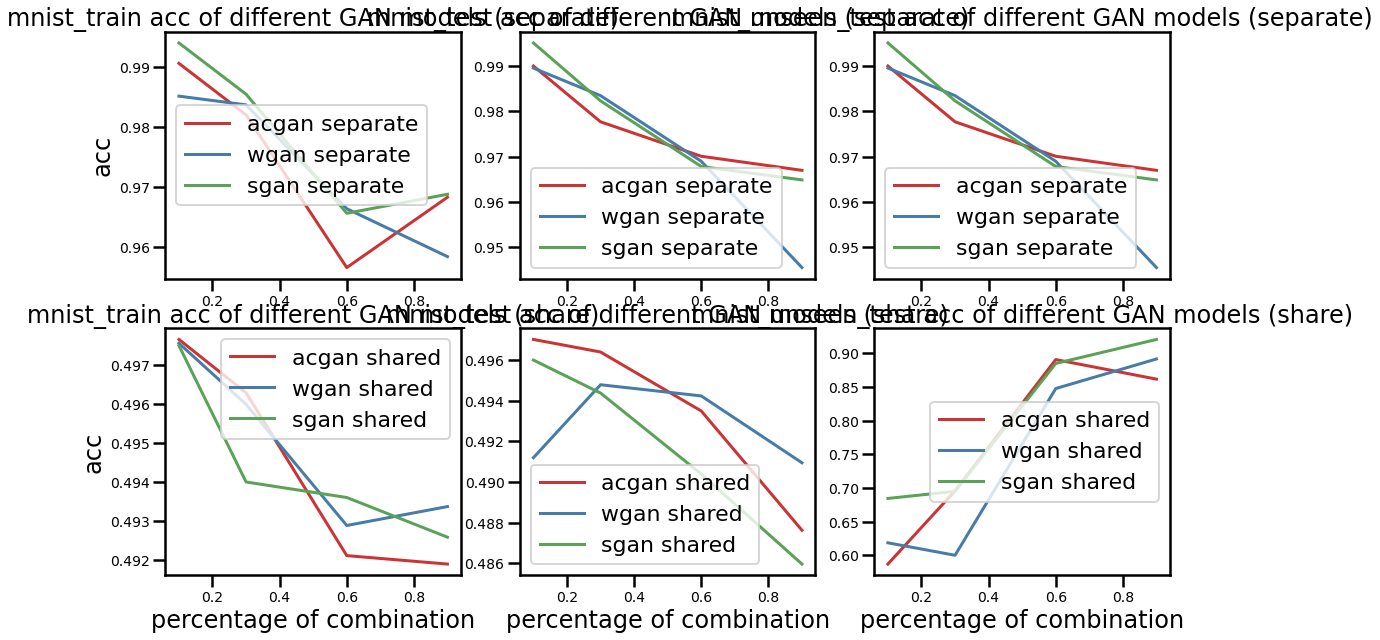

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
label = []
for key, value in all_train_all.items():
    if 'separate' in key:
        sns.lineplot(ax=axes[0, 0], y = value, x =  percentage)
        label.append(key)

axes[0, 0].legend(label)
axes[0, 0].set_title('mnist_train acc of different GAN models (separate)')
label = []        

for key, value in all_test_all.items():
    if 'separate' in key:
        sns.lineplot(ax=axes[0, 1], y = value, x =  percentage)
        label.append(key)

axes[0, 1].legend(label)
axes[0, 1].set_title('mnist_test acc of different GAN models (separate)')

label = []    

for key, value in all_unseen_test_all.items():
    if 'separate' in key:   
        sns.lineplot(ax=axes[0, 2], y = value, x =  percentage)
        label.append(key)

axes[0, 2].legend(label)
axes[0, 2].set_title('mnist_unseen_test acc of different GAN models (separate)')

label = []   


for key, value in all_train_all.items():
    if 'share' in key:
        sns.lineplot(ax=axes[1, 0], y = value, x =  percentage)
        label.append(key)

axes[1, 0].legend(label)
axes[1, 0].set_title('mnist_train acc of different GAN models (share)')
label = []        

for key, value in all_test_all.items():
    if 'share' in key:
        sns.lineplot(ax=axes[1, 1], y = value, x =  percentage)
        label.append(key)

axes[1, 1].legend(label)
axes[1, 1].set_title('mnist_test acc of different GAN models (share)')

label = []    

for key, value in all_unseen_test_all.items():
    if 'share' in key:   
        sns.lineplot(ax=axes[1, 2], y = value, x =  percentage)
        label.append(key)

axes[1, 2].legend(label)
axes[1, 2].set_title('mnist_unseen_test acc of different GAN models (share)')

label = []   









# axes[0, 0].legend(label)
# axes[0, 1].legend(label)
# axes[0, 0].set_title('111')
plt.setp(axes[-1, :], xlabel='percentage of combination')
plt.setp(axes[:, 0], ylabel='acc')
# axes[0, 0].('percentage of combination')
# axes.set_xlabels('percentage of combination')
# # axes[0, 0].ylabel('acc')
# # set_axis_labels
# axes.title('mnist_train acc of different GAN models (separate)')

[Text(0, 0.5, 'acc')]

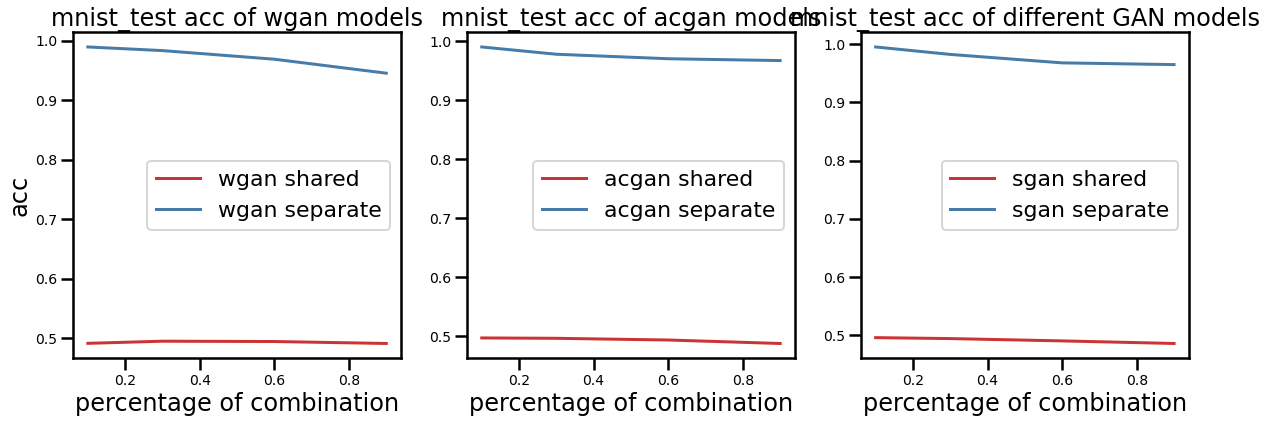

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
label = []
for key, value in all_test_all.items():
    if 'wgan' in key:
        sns.lineplot(ax=axes[0], y = value, x =  percentage)
        label.append(key)

axes[0].legend(label)
axes[0].set_title('mnist_test acc of wgan models')
label = []        

for key, value in all_test_all.items():
    if 'acgan' in key:
        sns.lineplot(ax=axes[1], y = value, x =  percentage)
        label.append(key)

axes[1].legend(label)
axes[1].set_title('mnist_test acc of acgan models')

label = []    

for key, value in all_test_all.items():
    if 'sgan' in key:   
        sns.lineplot(ax=axes[2], y = value, x =  percentage)
        label.append(key)

axes[2].legend(label)
axes[2].set_title('mnist_test acc of different GAN models')

label = []   











plt.setp(axes[:], xlabel='percentage of combination')
plt.setp(axes[0], ylabel='acc')

[Text(0, 0.5, 'acc')]

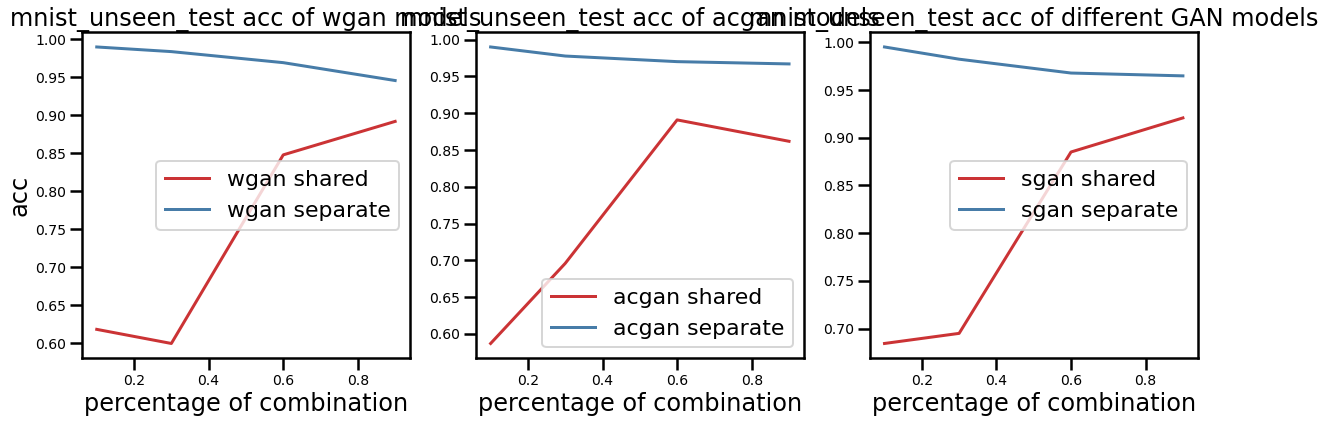

In [34]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
label = []
for key, value in all_unseen_test_all.items():
    if 'wgan' in key:
        sns.lineplot(ax=axes[0], y = value, x =  percentage)
        label.append(key)

axes[0].legend(label)
axes[0].set_title('mnist_unseen_test acc of wgan models')
label = []        

for key, value in all_unseen_test_all.items():
    if 'acgan' in key:
        sns.lineplot(ax=axes[1], y = value, x =  percentage)
        label.append(key)

axes[1].legend(label)
axes[1].set_title('mnist_unseen_test acc of acgan models')

label = []    

for key, value in all_unseen_test_all.items():
    if 'sgan' in key:   
        sns.lineplot(ax=axes[2], y = value, x =  percentage)
        label.append(key)

axes[2].legend(label)
axes[2].set_title('mnist_unseen_test acc of different GAN models')

label = []   











plt.setp(axes[:], xlabel='percentage of combination')
plt.setp(axes[0], ylabel='acc')